In [37]:
import numpy as np
np.random.seed(314159)
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split

import parameter_tuning
import plot_boundary
import analysis_functions as af

from metric_functions import compute_accuracy, compute_auc_from_scores
from kernel_SVM_functions import rbf_kernel
from classifiers import QUBOSoftMarginClassifier, SoftMarginKernelClassifier


In [14]:
filename = 'versicolor-virginica'

data = pd.read_csv(f'iris_data/{filename}.csv').to_numpy()

X = data[:, 1: -1]
t = data[:, -1]
#iris_setosa will be 1, iris-versicolor will be -1
t[t == 'Iris-versicolor'] = 1
t[t == 'Iris-virginica'] = -1
t = t.astype('float')

X_train, X_test, t_train, t_test = train_test_split(X, t, train_size = 0.4, shuffle = True, stratify = t)
t_train = t_train.reshape(-1, 1)
t_test = t_test.reshape(-1, 1)

## Tuning parameters for qSVM

In [15]:
B_values = [2, 3, 5, 10]
K_values = [2, 3, 4]
R_values = [0, 1, 3, 5]
gamma_values = [-1] + [2 ** i for i in range(-3, 3)]
kernel_func = rbf_kernel
#This results in a matrix with shape (4, 2, 4, 7)

run = False

if run:

    accuracy_results, auroc_results, times = parameter_tuning.tune_qsvm_parameters(X_train, t_train, B_values, K_values, R_values, gamma_values, kernel_func)

    np.save(f'results/QUBO-{filename}-accuracy', accuracy_results)
    np.save(f'results/QUBO-{filename}-auroc', auroc_results)
    np.save(f'results/QUBO-{filename}-time', times)

## Tuning parameters for kSVM

In [16]:
C_values = [2 ** i for i in range(0, 7)]
gamma_values = [-1] + [2 **i for i in range(-3, 3)]
kernel_func = rbf_kernel

run = False

if run:

    accuracy_results, auroc_results, times = parameter_tuning.tune_csvm_parameters(X_train, t_train, C_values, gamma_values, kernel_func)

    np.save(f'results/kSVM-{filename}-accuracy', accuracy_results)
    np.save(f'results/kSVM-{filename}-auroc', auroc_results)
    np.save(f'results/kSVM-{filename}-time', times)

## Get data from files

In [17]:
qSVM_accuracy = np.load(f'results/QUBO-{filename}-accuracy.npy')
qSVM_auroc = np.load(f'results/QUBO-{filename}-auroc.npy')

cSVM_accuracy = np.load(f'results/kSVM-{filename}-accuracy.npy')
cSVM_auroc = np.load(f'results/kSVM-{filename}-auroc.npy')

In [18]:
print(qSVM_accuracy.shape, cSVM_accuracy.shape)

(4, 3, 4, 7) (7, 7)


## Best models QUBOSVM
Finding best models based on Accuracy and then plotting them

In [19]:
print(f'cSVM best accuracy {np.max(cSVM_accuracy[:, 1: ])} \n cSVM best auroc {np.max(cSVM_auroc[:, 1: ])} \n')
print(f'qSVM best accuracy {np.max(qSVM_accuracy)} \n qSVM best auroc {np.max(qSVM_auroc)} \n')

cSVM best accuracy 0.95 
 cSVM best auroc 1.0 

qSVM best accuracy 0.97 
 qSVM best auroc 1.0 



In [46]:
val_list = [B_values, K_values, R_values, gamma_values]
model_indices = af.find_best(qSVM_auroc, 20)
top_models = [af.get_params(val_list, model_indices[i]) for i in range(len(model_indices))]

#top_model_acc = [qSVM_accuracy[index] for index in model_indices]
#top_model_auc = [qSVM_auroc[index] for index in model_indices]

In [47]:
tp_acc_mean = []
tp_acc_std = []

tp_auc_mean = []
tp_auc_std = []

kernel_func = rbf_kernel
n = 50

#Averaging the accuracy and auc for each parameter set over 50 models
for i, model_parameters in enumerate(top_models):

    accuracy = []
    auroc = []

    for j in range(n):
        
        qsmc = QUBOSoftMarginClassifier(model_parameters[0], model_parameters[1], model_parameters[2], kernel_func, model_parameters[3])
        qsmc = qsmc.make_QUBO_problem(X_train, t_train).fit(X_train, t_train)
        scores = qsmc.decision_function(X_test)
        preds = qsmc.predict(X_test)
        
        accuracy.append(compute_accuracy(preds, t_test))
        auroc.append(compute_auc_from_scores(scores, t_test))

    tp_acc_mean.append(np.mean(accuracy))
    tp_acc_std.append(np.std(accuracy))

    tp_auc_mean.append(np.mean(auroc))
    tp_auc_std.append(np.std(auroc))

In [57]:
display(tp_auc_mean, tp_acc_mean)

[0.9541555555555555,
 0.9501777777777778,
 0.9500444444444445,
 0.9533555555555554,
 0.9573555555555557,
 0.9715555555555555,
 0.9672,
 0.9507333333333334,
 0.9484444444444445,
 0.9521333333333334,
 0.9542444444444445,
 0.9583333333333333,
 0.9740666666666666,
 0.9774888888888889,
 0.9530222222222221,
 0.9505555555555554,
 0.9524888888888888,
 0.9551111111111112,
 0.9529111111111113,
 0.9558222222222222]

[0.704,
 0.6356666666666666,
 0.508,
 0.7743333333333333,
 0.8323333333333334,
 0.8873333333333333,
 0.8980000000000001,
 0.7316666666666667,
 0.6013333333333333,
 0.6259999999999999,
 0.8049999999999998,
 0.8556666666666666,
 0.8956666666666666,
 0.9036666666666666,
 0.7859999999999999,
 0.7353333333333333,
 0.7266666666666667,
 0.7866666666666668,
 0.7193333333333334,
 0.8036666666666668]

In [74]:
np.array(top_models)[np.argsort(-np.array(tp_auc_mean))]

array([[2.   , 4.   , 0.   , 2.   ],
       [2.   , 4.   , 0.   , 1.   ],
       [2.   , 3.   , 0.   , 1.   ],
       [2.   , 3.   , 0.   , 4.   ],
       [2.   , 4.   , 0.   , 0.25 ],
       [2.   , 3.   , 0.   , 0.25 ],
       [3.   , 4.   , 0.   , 0.125],
       [3.   , 3.   , 0.   , 0.125],
       [2.   , 4.   , 0.   , 0.125],
       [2.   , 2.   , 0.   , 0.125],
       [2.   , 3.   , 0.   , 0.125],
       [2.   , 4.   , 1.   , 0.125],
       [3.   , 3.   , 1.   , 0.125],
       [3.   , 2.   , 0.   , 0.125],
       [2.   , 3.   , 5.   , 0.125],
       [2.   , 3.   , 1.   , 0.125],
       [2.   , 4.   , 3.   , 0.125],
       [2.   , 2.   , 1.   , 0.125],
       [2.   , 2.   , 5.   , 0.125],
       [2.   , 3.   , 3.   , 0.125]])

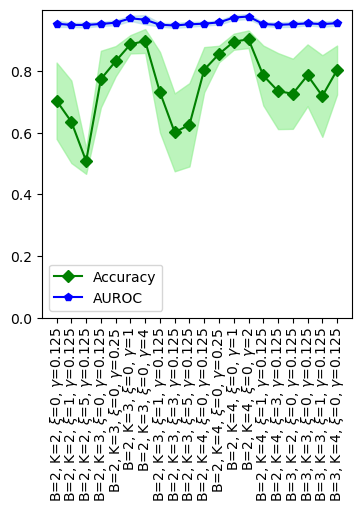

In [49]:
fig, ax = plt.subplots(figsize = (4, 4))

af.plot_top_models(top_models, np.array([tp_acc_mean, tp_acc_std]), np.array([tp_auc_mean, tp_auc_std]), fig = fig, ax = ax)
plt.savefig('plots/virgi-versi-quboplot.png', dpi = 256)
plt.show()

## Best cSVM

In [50]:
cSVM_auroc

array([[  nan, 0.975, 0.95 , 0.975, 0.925, 0.975, 0.925],
       [  nan, 0.825, 0.975, 0.975, 0.925, 0.95 , 0.95 ],
       [  nan, 0.95 , 0.9  , 0.875, 1.   , 0.95 , 0.9  ],
       [  nan, 0.8  , 0.825, 0.95 , 0.8  , 0.95 , 0.9  ],
       [  nan, 0.775, 0.95 , 0.775, 0.8  , 0.975, 0.9  ],
       [  nan, 0.95 , 0.7  , 0.7  , 1.   , 0.975, 0.9  ],
       [  nan, 0.7  , 0.7  , 1.   , 1.   , 0.975, 0.9  ]])

## cSVM boundary plot

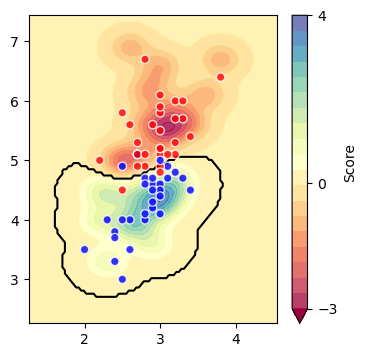

In [25]:
#Showing the decision boundary between petal length and petal width -- which divides the data really well. 
dimensions = [1, 2]
clf = SoftMarginKernelClassifier(1, kernel_func, 16)
clf = clf.fit(X_train, t_train)
scores = clf.decision_function(X_test)
preds = clf.predict(X_test)
c_prob_dist = clf.predict_proba(X_test)

clf.support_vectors = clf.support_vectors[:, dimensions]
clf.alphas = clf.alphas[dimensions]
plot_X_test = X_test[:, dimensions]
plot_t_test = t_test

plot_boundary.plot(plot_X_test, plot_t_test, clf, contour_func = 'decision_function', colorbar = True)

## qSVM boundary plot

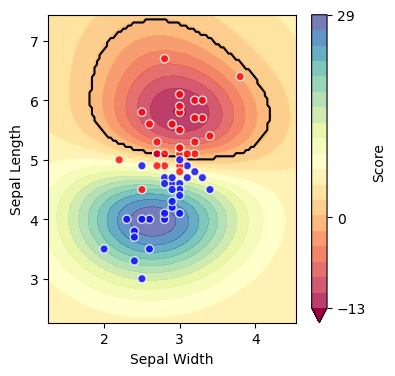

In [26]:
#Showing the decision boundary between petal length and petal width -- which divides the data really well. 
clf = QUBOSoftMarginClassifier(2, 3, 5, kernel_func, 1)
clf = clf.make_QUBO_problem(X_train, t_train).fit(X_train, t_train)
scores = clf.decision_function(X_test)
preds = clf.predict(X_test)
q_prob_dist = clf.predict_proba(X_test)

clf.support_vectors = clf.support_vectors[:, dimensions]
clf.alphas = clf.alphas[dimensions]

fig, ax = plt.subplots(figsize = (4, 4))

plot_boundary.plot(plot_X_test, plot_t_test, clf, contour_func = 'decision_function', colorbar = True, fig = fig, ax = ax)
ax.set_ylabel('Sepal Length')
ax.set_xlabel('Sepal Width')
plt.show()

/Users/isaaccopson/Desktop/Research Project/ResearchProjectRepo/Main/plot_boundary.py:52: UserWarning: No contour levels were found within the data range.
  cs = ax.contour(xx, yy, prediction, [0], cmap = 'bone')


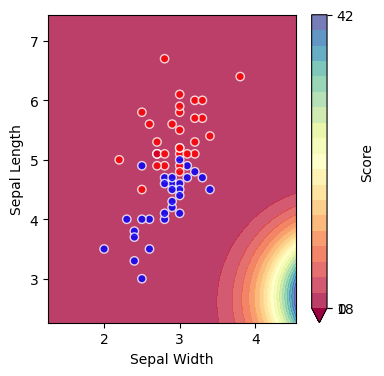

In [27]:
#Showing the decision boundary between petal length and petal width -- which divides the data really well. 
dimensions = [0, 1]
clf = QUBOSoftMarginClassifier(5, 3, 0, kernel_func, 1)
clf = clf.make_QUBO_problem(X_train, t_train).fit(X_train, t_train)
scores = clf.decision_function(X_test)
preds = clf.predict(X_test)
q_prob_dist = clf.predict_proba(X_test)

clf.support_vectors = clf.support_vectors[:, dimensions]
clf.alphas = clf.alphas[dimensions]

fig, ax = plt.subplots(figsize = (4, 4))

plot_boundary.plot(plot_X_test, plot_t_test, clf, contour_func = 'decision_function', colorbar = True, fig = fig, ax = ax)
ax.set_ylabel('Sepal Length')
ax.set_xlabel('Sepal Width')
plt.show()

### Probability distribution of the models

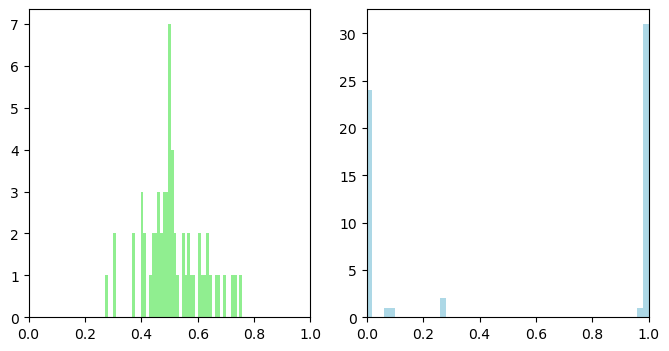

In [28]:
fig, ax = plt.subplots(1, 2, figsize = (8, 4))

ax[0].hist(c_prob_dist, label = 'cSVM probability distribution', color = 'lightgreen', bins = 50)
ax[1].hist(q_prob_dist, label = 'qSVM probability distribution', color = 'lightblue', bins = 50)

ax[0].set_xlim(0, 1)
ax[1].set_xlim(0, 1)

plt.show()

In [29]:
qSVM_accuracy.shape, cSVM_accuracy.shape

((4, 3, 4, 7), (7, 7))

## Variance

4 different values of R. For each other combination of the other 3 hyper-parameters -- B, K, gamma -- what is the variance of R as it varies. <br>
We end up with a 4x2x7 matrix with each element corresponding to the variance of the results for each different combination of B, K, gamma, which is then the variance over R. <br>
Would the variance of the variance the hyper-parameter be useful? <br>
Would the mean of the variance for each hyper-parameter be useful? No. <br>
Ok, basically both of them might be a better indication as to how important the parameters are. They can define a distribution which will be easier to understand than a list of numbers.
Where the variance appears would also be useful, but might be a little too in depth for the current level of analysis.
<br>
Note: cSVM nailed the classification, so it doesn't have any variance.

In [75]:
"""QUBO SVM"""

qSVM_variances = {'B': {}, 'K': {}, 'R': {}, 'gamma': {}}

for i, key in enumerate(list(qSVM_variances.keys())):
    auc = np.var(qSVM_auroc, axis = i)
    acc = np.var(qSVM_accuracy, axis = i)
    qSVM_variances[key]['auc'] = (np.mean(auc), np.var(auc))
    qSVM_variances[key]['acc'] = (np.mean(acc), np.var(acc))

In [80]:
[ (key, qSVM_variances[key]['auc']) for key in list(qSVM_variances.keys()) ]

[('B', (7.841796874999998e-05, 8.14320473443896e-09)),
 ('K', (3.531746031746035e-05, 3.3378360024565396e-09)),
 ('R', (6.0458519345238096e-05, 5.178202133870705e-09)),
 ('gamma', (0.11835448022959183, 4.1848595227960685e-06))]

## C, R, and Gamma

In [32]:
C_values = np.zeros((len(B_values), len(K_values)))

for i, B in enumerate(B_values):
    for j, K in enumerate(K_values):
       C_values[i, j] = np.sum([B ** k for k in range(K)])
C_values = C_values.flatten()
C_values

array([   3.,    7.,   15.,    4.,   13.,   40.,    6.,   31.,  156.,
         11.,  111., 1111.])

In [33]:
C_qSVM_accuracy = np.array([qSVM_accuracy[i, j, :, :] for i in range(len(B_values)) for j in range(len(K_values))])

In [34]:
C_qSVM_accuracy

array([[[0.49  , 0.7275, 0.7925, 0.8525, 0.85  , 0.905 , 0.88  ],
        [0.495 , 0.6275, 0.665 , 0.74  , 0.755 , 0.815 , 0.7775],
        [0.495 , 0.5   , 0.5275, 0.6025, 0.6975, 0.775 , 0.7825],
        [0.495 , 0.505 , 0.525 , 0.56  , 0.6825, 0.72  , 0.7525]],

       [[0.4925, 0.7925, 0.915 , 0.9075, 0.945 , 0.9225, 0.935 ],
        [0.4875, 0.6975, 0.78  , 0.8275, 0.83  , 0.855 , 0.8525],
        [0.49  , 0.585 , 0.6925, 0.7925, 0.845 , 0.8675, 0.815 ],
        [0.4875, 0.5625, 0.69  , 0.7925, 0.825 , 0.85  , 0.84  ]],

       [[0.4825, 0.8525, 0.91  , 0.925 , 0.9525, 0.97  , 0.97  ],
        [0.4725, 0.83  , 0.855 , 0.8825, 0.8875, 0.91  , 0.865 ],
        [0.485 , 0.715 , 0.79  , 0.86  , 0.8775, 0.8825, 0.87  ],
        [0.4875, 0.715 , 0.8175, 0.845 , 0.88  , 0.8925, 0.86  ]],

       [[0.49  , 0.725 , 0.78  , 0.8525, 0.8875, 0.88  , 0.8775],
        [0.4925, 0.5875, 0.6175, 0.695 , 0.7425, 0.7725, 0.7675],
        [0.49  , 0.5125, 0.5425, 0.62  , 0.6775, 0.7475, 0.74  ],
    

In [35]:
print(np.unravel_index(np.argmax(qSVM_accuracy), qSVM_accuracy.shape))
print(B_values[0], K_values[1], R_values[0], gamma_values[1])

(0, 2, 0, 5)
2 3 0 0.125
